# Train model Bayesian Neural Network

We train and evaluate the BNN on the dataset which we loaded earlier.

Credits to Felix Laumann (https://github.com/felix-laumann/Bayesian_CNN) for the method of training BNN with Bayes by Backprop and the model code.

In [1]:
import torch
import pickle
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
import random
from torch.autograd import Variable
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import pandas as pd
from copy import copy 
from ML_models.BBBlayers import BBBLinearFactorial
from ML_models.BBBlayers import GaussianVariationalInference
from ML_models.BNN_Wrapper import BNN_Wrapper
from ML_models.BNN_Wrapper import BNN_Full
import seaborn as sns

from scipy.stats import skew
from scipy.stats import kurtosis 
from scipy.stats import sem
from scipy.fftpack import fft
from sklearn.metrics import f1_score

## Load data and label outputs

In [2]:
pickle_path="pickles/"
data_input = pickle.load( open( pickle_path+"data_input_data_1Hz_full.p", "rb" ) )
data_output = pickle.load( open( pickle_path+"zema_outputs.p", "rb" ) )

output_labels = [{0: "Optimal", 1: "Reduced", 2: "Nearly Fail"},
 {0: "Optimal", 1: "Small lag", 2: "Severe lag", 3: "Nearly Fail"},
 {0: "No Leakage", 1: "Weak Leakage", 2: "Severe Leakage"},
 {0: "Optimal", 1: "Slightly Reduced", 2: "Severely Reduced", 3: "Nearly Fail"},
 {0: "Stable", 1: "Unstable"}]
output_sizes = [3,4,3,4,2]


## Initialization

Setup parameters such as learning rate, number of Monte Carlo samples during predictions, training epoch, certainty threshold 



In [3]:
learning_rate = 0.005
num_samples = 50
num_epochs = 300
certainty_threshold  = 80

X_data = data_input
Y_data = data_output


## Shuffle data
1. Shuffle data randomly to have a random distribution
2. Split the time series into segments if necessary (n=1 means no segmentation occurs)

In [4]:
randomShuffling= True

#randomShuffling
if(randomShuffling == True):
    index_list = np.arange(X_data.shape[0])
    random.shuffle(index_list)
    Y_data=Y_data[index_list,:]
    X_data=X_data[index_list,:,:]

def split_segment(X_data,split_n =1):
    X_data_split=np.split(X_data,split_n,axis=1)
    X_data_split=np.moveaxis(X_data_split, 0, -2)
    X_data_split=X_data_split.reshape((X_data_split.shape[0],X_data_split.shape[1],-1))
    return X_data_split

X_data=split_segment(X_data)

## Train and evaluate data in k-fold validation
* Setup empty arrays for keeping results from each k-fold validation iteration

* Training consists of two loops:
    1. Outer loop: Train a model for each prediction task (from valve, pump, accumulator, etc)
    2. Inner loop: k-fold iteration
    
* Results are stored in arrays 

[ 441  442  443 ... 2202 2203 2204] [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 23

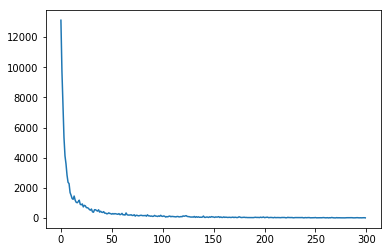

<Figure size 432x288 with 0 Axes>

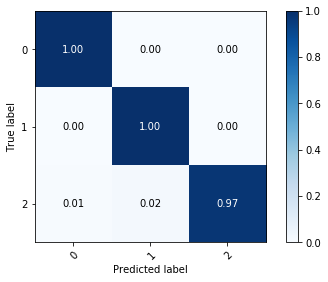

<Figure size 432x288 with 0 Axes>

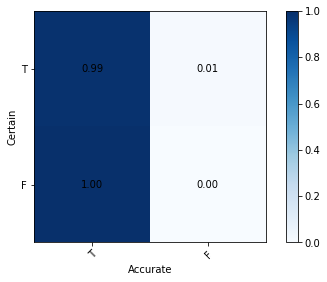

<Figure size 432x288 with 0 Axes>

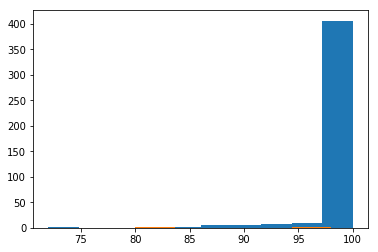

[   0    1    2 ... 2202 2203 2204] [441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458
 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476
 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494
 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512
 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530
 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548
 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566
 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584
 585 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600 601 602
 603 604 605 606 607 608 609 610 611 612 613 614 615 616 617 618 619 620
 621 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637 638
 639 640 641 642 643 644 645 646 647 648 649 650 651 652 653 654 655 656
 657 658 659 660 661 662 663 664 665 666 667 668 669 670 671 672 673 674
 675 676 677 67

<Figure size 432x288 with 0 Axes>

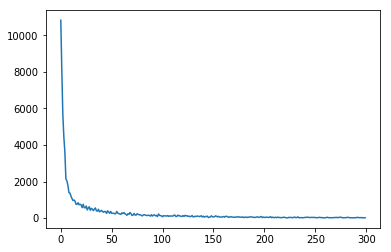

<Figure size 432x288 with 0 Axes>

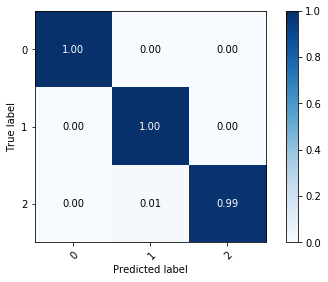

<Figure size 432x288 with 0 Axes>

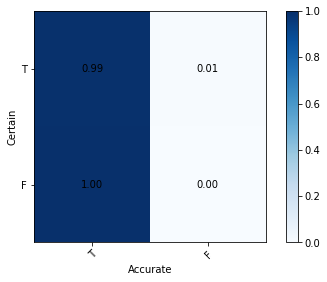

<Figure size 432x288 with 0 Axes>

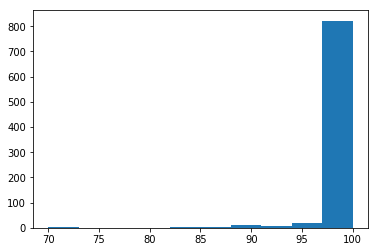

[   0    1    2 ... 2202 2203 2204] [ 882  883  884  885  886  887  888  889  890  891  892  893  894  895
  896  897  898  899  900  901  902  903  904  905  906  907  908  909
  910  911  912  913  914  915  916  917  918  919  920  921  922  923
  924  925  926  927  928  929  930  931  932  933  934  935  936  937
  938  939  940  941  942  943  944  945  946  947  948  949  950  951
  952  953  954  955  956  957  958  959  960  961  962  963  964  965
  966  967  968  969  970  971  972  973  974  975  976  977  978  979
  980  981  982  983  984  985  986  987  988  989  990  991  992  993
  994  995  996  997  998  999 1000 1001 1002 1003 1004 1005 1006 1007
 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1019 1020 1021
 1022 1023 1024 1025 1026 1027 1028 1029 1030 1031 1032 1033 1034 1035
 1036 1037 1038 1039 1040 1041 1042 1043 1044 1045 1046 1047 1048 1049
 1050 1051 1052 1053 1054 1055 1056 1057 1058 1059 1060 1061 1062 1063
 1064 1065 1066 1067 1068 1069 1070 1071 

<Figure size 432x288 with 0 Axes>

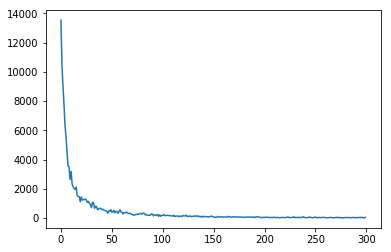

<Figure size 432x288 with 0 Axes>

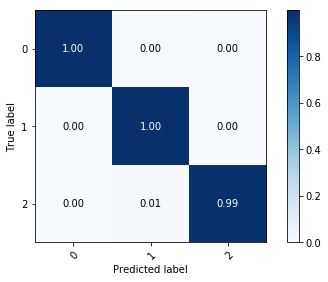

<Figure size 432x288 with 0 Axes>

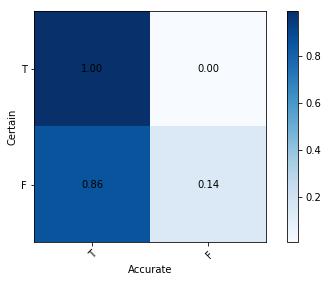

<Figure size 432x288 with 0 Axes>

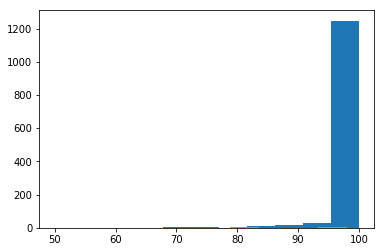

[   0    1    2 ... 2202 2203 2204] [1323 1324 1325 1326 1327 1328 1329 1330 1331 1332 1333 1334 1335 1336
 1337 1338 1339 1340 1341 1342 1343 1344 1345 1346 1347 1348 1349 1350
 1351 1352 1353 1354 1355 1356 1357 1358 1359 1360 1361 1362 1363 1364
 1365 1366 1367 1368 1369 1370 1371 1372 1373 1374 1375 1376 1377 1378
 1379 1380 1381 1382 1383 1384 1385 1386 1387 1388 1389 1390 1391 1392
 1393 1394 1395 1396 1397 1398 1399 1400 1401 1402 1403 1404 1405 1406
 1407 1408 1409 1410 1411 1412 1413 1414 1415 1416 1417 1418 1419 1420
 1421 1422 1423 1424 1425 1426 1427 1428 1429 1430 1431 1432 1433 1434
 1435 1436 1437 1438 1439 1440 1441 1442 1443 1444 1445 1446 1447 1448
 1449 1450 1451 1452 1453 1454 1455 1456 1457 1458 1459 1460 1461 1462
 1463 1464 1465 1466 1467 1468 1469 1470 1471 1472 1473 1474 1475 1476
 1477 1478 1479 1480 1481 1482 1483 1484 1485 1486 1487 1488 1489 1490
 1491 1492 1493 1494 1495 1496 1497 1498 1499 1500 1501 1502 1503 1504
 1505 1506 1507 1508 1509 1510 1511 1512 

<Figure size 432x288 with 0 Axes>

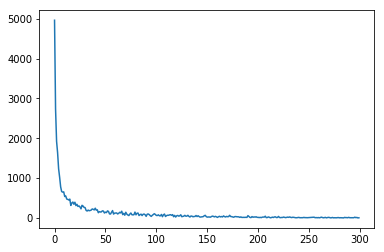

<Figure size 432x288 with 0 Axes>

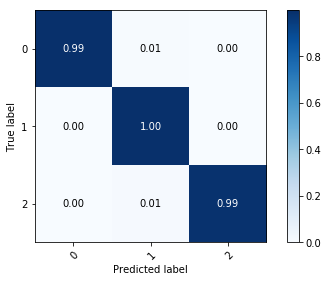

<Figure size 432x288 with 0 Axes>

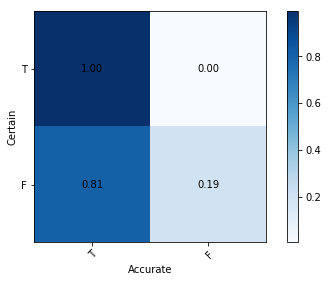

<Figure size 432x288 with 0 Axes>

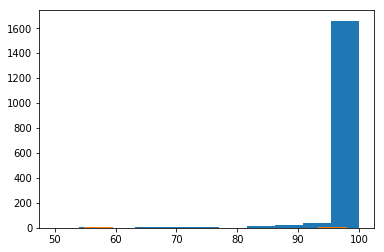

[   0    1    2 ... 1761 1762 1763] [1764 1765 1766 1767 1768 1769 1770 1771 1772 1773 1774 1775 1776 1777
 1778 1779 1780 1781 1782 1783 1784 1785 1786 1787 1788 1789 1790 1791
 1792 1793 1794 1795 1796 1797 1798 1799 1800 1801 1802 1803 1804 1805
 1806 1807 1808 1809 1810 1811 1812 1813 1814 1815 1816 1817 1818 1819
 1820 1821 1822 1823 1824 1825 1826 1827 1828 1829 1830 1831 1832 1833
 1834 1835 1836 1837 1838 1839 1840 1841 1842 1843 1844 1845 1846 1847
 1848 1849 1850 1851 1852 1853 1854 1855 1856 1857 1858 1859 1860 1861
 1862 1863 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875
 1876 1877 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889
 1890 1891 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903
 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917
 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931
 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945
 1946 1947 1948 1949 1950 1951 1952 1953 

<Figure size 432x288 with 0 Axes>

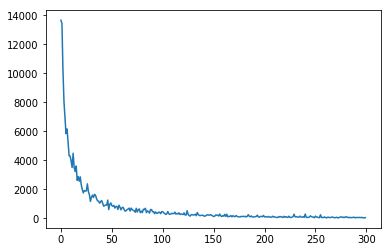

<Figure size 432x288 with 0 Axes>

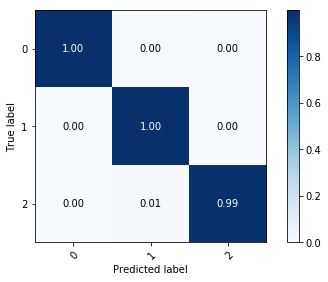

<Figure size 432x288 with 0 Axes>

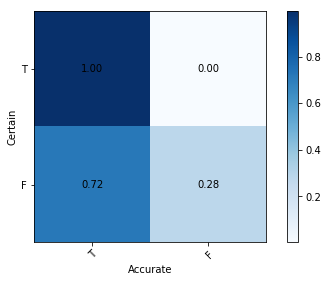

<Figure size 432x288 with 0 Axes>

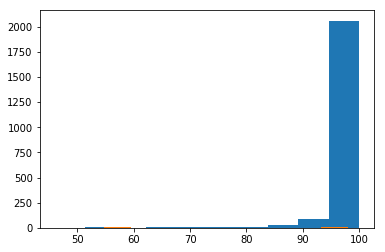

Target output:  0
F1 SCORE:  0.9935298563869992 +- 0.0006539809038948887 [0.9909297052154195, 0.9943310657596371, 0.9939531368102796, 0.9943310657596371, 0.9941043083900227]
P(Acc | Certain):  0.9948817684799582 +- 0.0011175664038947306 [0.9908883826879271, 0.9942987457240593, 0.9954163483575248, 0.9965576592082617, 0.9972477064220183]
P(Acc | Uncertain):  0.8773333333333333 +- 0.05470547817544079 [1.0, 1.0, 0.8571428571428571, 0.8095238095238095, 0.72]
[ 441  442  443 ... 2202 2203 2204] [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124

<Figure size 432x288 with 0 Axes>

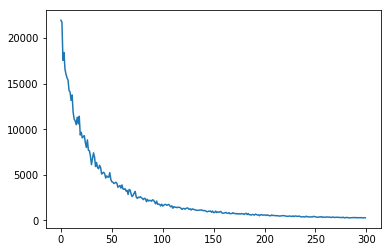

<Figure size 432x288 with 0 Axes>

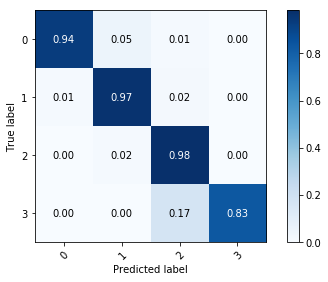

<Figure size 432x288 with 0 Axes>

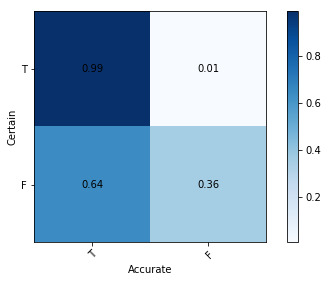

<Figure size 432x288 with 0 Axes>

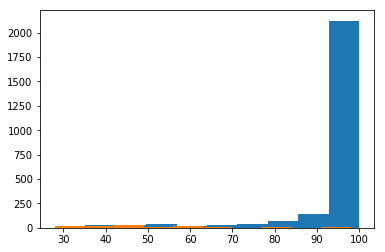

[   0    1    2 ... 2202 2203 2204] [441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458
 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476
 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494
 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512
 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530
 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548
 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566
 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584
 585 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600 601 602
 603 604 605 606 607 608 609 610 611 612 613 614 615 616 617 618 619 620
 621 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637 638
 639 640 641 642 643 644 645 646 647 648 649 650 651 652 653 654 655 656
 657 658 659 660 661 662 663 664 665 666 667 668 669 670 671 672 673 674
 675 676 677 67

<Figure size 432x288 with 0 Axes>

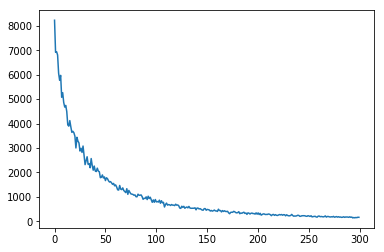

<Figure size 432x288 with 0 Axes>

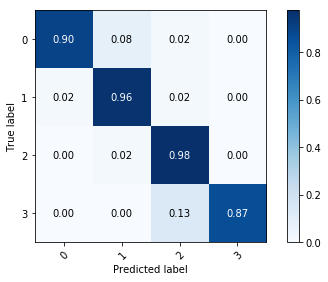

<Figure size 432x288 with 0 Axes>

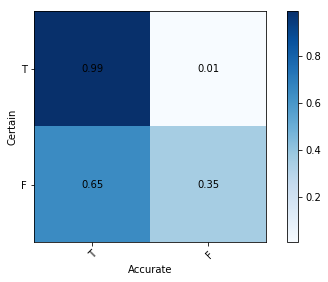

<Figure size 432x288 with 0 Axes>

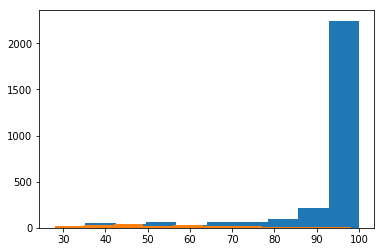

[   0    1    2 ... 2202 2203 2204] [ 882  883  884  885  886  887  888  889  890  891  892  893  894  895
  896  897  898  899  900  901  902  903  904  905  906  907  908  909
  910  911  912  913  914  915  916  917  918  919  920  921  922  923
  924  925  926  927  928  929  930  931  932  933  934  935  936  937
  938  939  940  941  942  943  944  945  946  947  948  949  950  951
  952  953  954  955  956  957  958  959  960  961  962  963  964  965
  966  967  968  969  970  971  972  973  974  975  976  977  978  979
  980  981  982  983  984  985  986  987  988  989  990  991  992  993
  994  995  996  997  998  999 1000 1001 1002 1003 1004 1005 1006 1007
 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1019 1020 1021
 1022 1023 1024 1025 1026 1027 1028 1029 1030 1031 1032 1033 1034 1035
 1036 1037 1038 1039 1040 1041 1042 1043 1044 1045 1046 1047 1048 1049
 1050 1051 1052 1053 1054 1055 1056 1057 1058 1059 1060 1061 1062 1063
 1064 1065 1066 1067 1068 1069 1070 1071 

<Figure size 432x288 with 0 Axes>

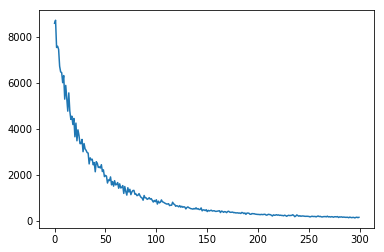

<Figure size 432x288 with 0 Axes>

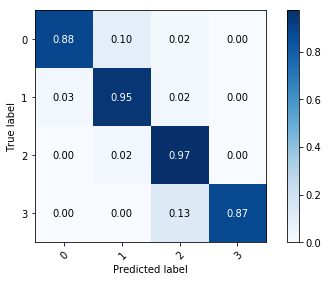

<Figure size 432x288 with 0 Axes>

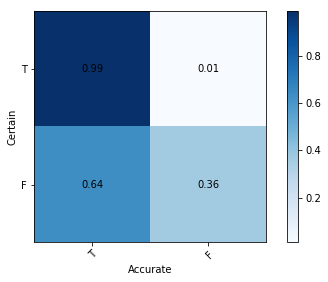

<Figure size 432x288 with 0 Axes>

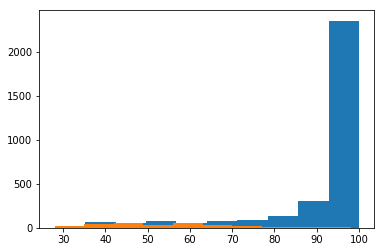

[   0    1    2 ... 2202 2203 2204] [1323 1324 1325 1326 1327 1328 1329 1330 1331 1332 1333 1334 1335 1336
 1337 1338 1339 1340 1341 1342 1343 1344 1345 1346 1347 1348 1349 1350
 1351 1352 1353 1354 1355 1356 1357 1358 1359 1360 1361 1362 1363 1364
 1365 1366 1367 1368 1369 1370 1371 1372 1373 1374 1375 1376 1377 1378
 1379 1380 1381 1382 1383 1384 1385 1386 1387 1388 1389 1390 1391 1392
 1393 1394 1395 1396 1397 1398 1399 1400 1401 1402 1403 1404 1405 1406
 1407 1408 1409 1410 1411 1412 1413 1414 1415 1416 1417 1418 1419 1420
 1421 1422 1423 1424 1425 1426 1427 1428 1429 1430 1431 1432 1433 1434
 1435 1436 1437 1438 1439 1440 1441 1442 1443 1444 1445 1446 1447 1448
 1449 1450 1451 1452 1453 1454 1455 1456 1457 1458 1459 1460 1461 1462
 1463 1464 1465 1466 1467 1468 1469 1470 1471 1472 1473 1474 1475 1476
 1477 1478 1479 1480 1481 1482 1483 1484 1485 1486 1487 1488 1489 1490
 1491 1492 1493 1494 1495 1496 1497 1498 1499 1500 1501 1502 1503 1504
 1505 1506 1507 1508 1509 1510 1511 1512 

<Figure size 432x288 with 0 Axes>

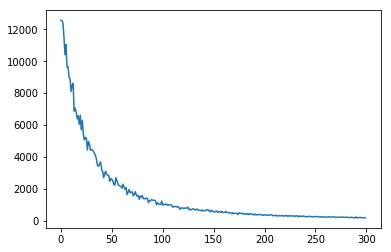

<Figure size 432x288 with 0 Axes>

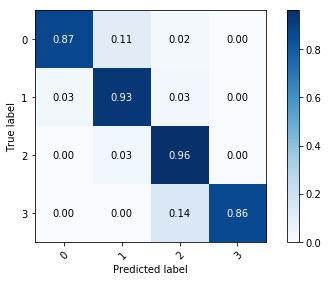

<Figure size 432x288 with 0 Axes>

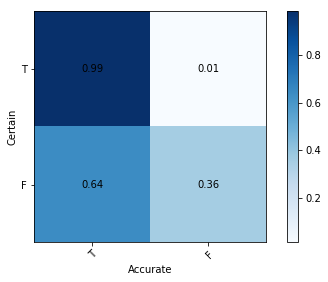

<Figure size 432x288 with 0 Axes>

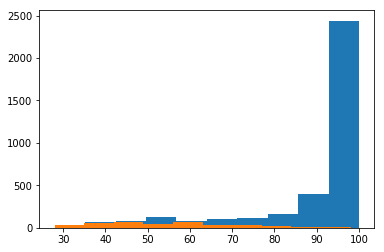

[   0    1    2 ... 1761 1762 1763] [1764 1765 1766 1767 1768 1769 1770 1771 1772 1773 1774 1775 1776 1777
 1778 1779 1780 1781 1782 1783 1784 1785 1786 1787 1788 1789 1790 1791
 1792 1793 1794 1795 1796 1797 1798 1799 1800 1801 1802 1803 1804 1805
 1806 1807 1808 1809 1810 1811 1812 1813 1814 1815 1816 1817 1818 1819
 1820 1821 1822 1823 1824 1825 1826 1827 1828 1829 1830 1831 1832 1833
 1834 1835 1836 1837 1838 1839 1840 1841 1842 1843 1844 1845 1846 1847
 1848 1849 1850 1851 1852 1853 1854 1855 1856 1857 1858 1859 1860 1861
 1862 1863 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875
 1876 1877 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889
 1890 1891 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903
 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917
 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931
 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945
 1946 1947 1948 1949 1950 1951 1952 1953 

<Figure size 432x288 with 0 Axes>

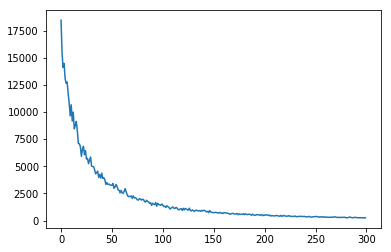

<Figure size 432x288 with 0 Axes>

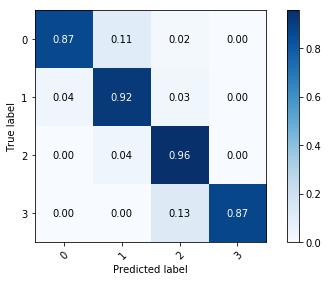

<Figure size 432x288 with 0 Axes>

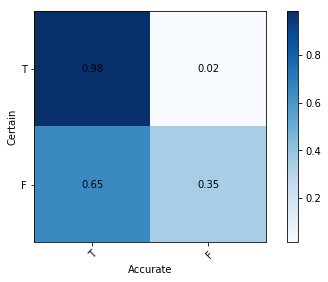

<Figure size 432x288 with 0 Axes>

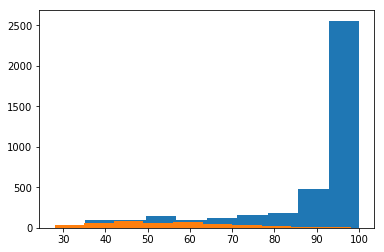

Target output:  1
F1 SCORE:  0.9230903790087464 +- 0.010276024503798158 [0.9554043839758125, 0.9358600583090378, 0.9195011337868481, 0.9062736205593348, 0.8984126984126984]
P(Acc | Certain):  0.9894242947009813 +- 0.0018893413199378155 [0.9948892674616695, 0.9918730650154799, 0.9897345132743363, 0.9862114248194354, 0.9844132029339854]
P(Acc | Uncertain):  0.6446576085351627 +- 0.0023821201108178485 [0.6442953020134228, 0.6481113320079522, 0.6372688477951636, 0.6424702058504875, 0.6511423550087874]
[ 441  442  443 ... 2202 2203 2204] [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 11

<Figure size 432x288 with 0 Axes>

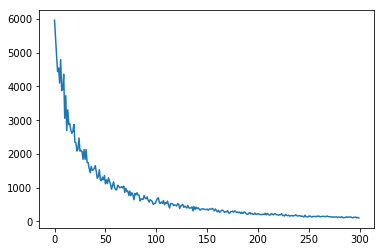

<Figure size 432x288 with 0 Axes>

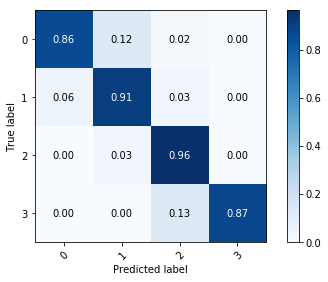

<Figure size 432x288 with 0 Axes>

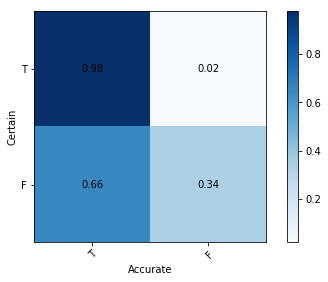

<Figure size 432x288 with 0 Axes>

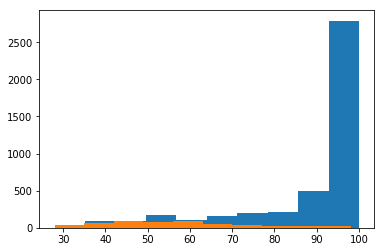

[   0    1    2 ... 2202 2203 2204] [441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458
 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476
 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494
 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512
 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530
 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548
 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566
 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584
 585 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600 601 602
 603 604 605 606 607 608 609 610 611 612 613 614 615 616 617 618 619 620
 621 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637 638
 639 640 641 642 643 644 645 646 647 648 649 650 651 652 653 654 655 656
 657 658 659 660 661 662 663 664 665 666 667 668 669 670 671 672 673 674
 675 676 677 67

<Figure size 432x288 with 0 Axes>

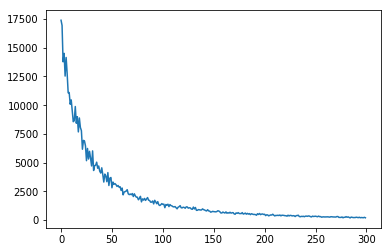

<Figure size 432x288 with 0 Axes>

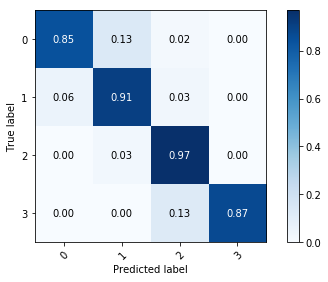

<Figure size 432x288 with 0 Axes>

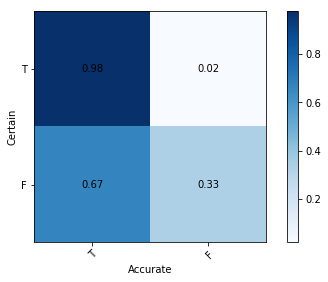

<Figure size 432x288 with 0 Axes>

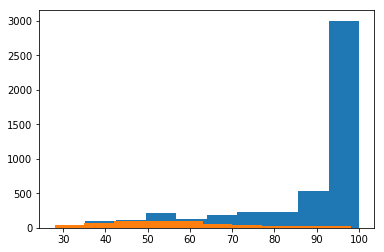

[   0    1    2 ... 2202 2203 2204] [ 882  883  884  885  886  887  888  889  890  891  892  893  894  895
  896  897  898  899  900  901  902  903  904  905  906  907  908  909
  910  911  912  913  914  915  916  917  918  919  920  921  922  923
  924  925  926  927  928  929  930  931  932  933  934  935  936  937
  938  939  940  941  942  943  944  945  946  947  948  949  950  951
  952  953  954  955  956  957  958  959  960  961  962  963  964  965
  966  967  968  969  970  971  972  973  974  975  976  977  978  979
  980  981  982  983  984  985  986  987  988  989  990  991  992  993
  994  995  996  997  998  999 1000 1001 1002 1003 1004 1005 1006 1007
 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1019 1020 1021
 1022 1023 1024 1025 1026 1027 1028 1029 1030 1031 1032 1033 1034 1035
 1036 1037 1038 1039 1040 1041 1042 1043 1044 1045 1046 1047 1048 1049
 1050 1051 1052 1053 1054 1055 1056 1057 1058 1059 1060 1061 1062 1063
 1064 1065 1066 1067 1068 1069 1070 1071 

<Figure size 432x288 with 0 Axes>

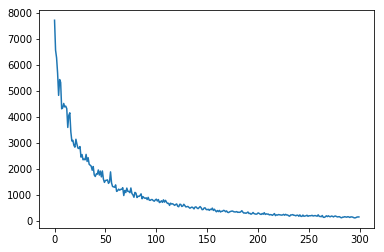

<Figure size 432x288 with 0 Axes>

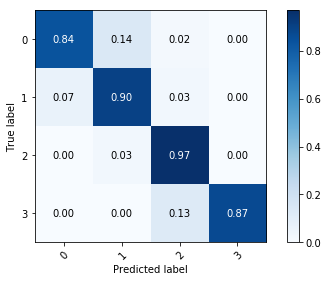

<Figure size 432x288 with 0 Axes>

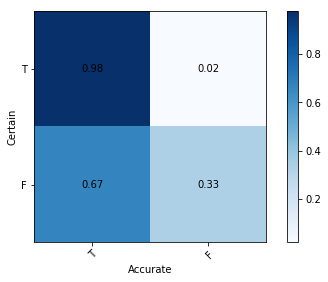

<Figure size 432x288 with 0 Axes>

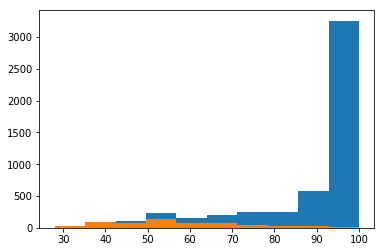

[   0    1    2 ... 2202 2203 2204] [1323 1324 1325 1326 1327 1328 1329 1330 1331 1332 1333 1334 1335 1336
 1337 1338 1339 1340 1341 1342 1343 1344 1345 1346 1347 1348 1349 1350
 1351 1352 1353 1354 1355 1356 1357 1358 1359 1360 1361 1362 1363 1364
 1365 1366 1367 1368 1369 1370 1371 1372 1373 1374 1375 1376 1377 1378
 1379 1380 1381 1382 1383 1384 1385 1386 1387 1388 1389 1390 1391 1392
 1393 1394 1395 1396 1397 1398 1399 1400 1401 1402 1403 1404 1405 1406
 1407 1408 1409 1410 1411 1412 1413 1414 1415 1416 1417 1418 1419 1420
 1421 1422 1423 1424 1425 1426 1427 1428 1429 1430 1431 1432 1433 1434
 1435 1436 1437 1438 1439 1440 1441 1442 1443 1444 1445 1446 1447 1448
 1449 1450 1451 1452 1453 1454 1455 1456 1457 1458 1459 1460 1461 1462
 1463 1464 1465 1466 1467 1468 1469 1470 1471 1472 1473 1474 1475 1476
 1477 1478 1479 1480 1481 1482 1483 1484 1485 1486 1487 1488 1489 1490
 1491 1492 1493 1494 1495 1496 1497 1498 1499 1500 1501 1502 1503 1504
 1505 1506 1507 1508 1509 1510 1511 1512 

<Figure size 432x288 with 0 Axes>

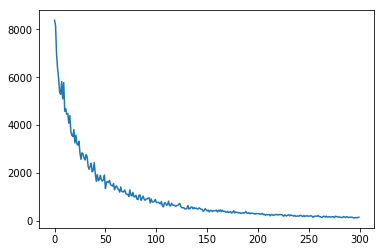

<Figure size 432x288 with 0 Axes>

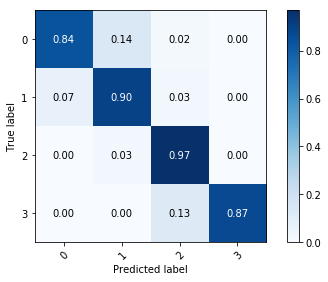

<Figure size 432x288 with 0 Axes>

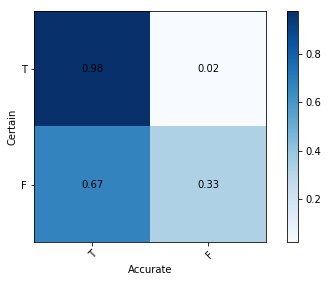

<Figure size 432x288 with 0 Axes>

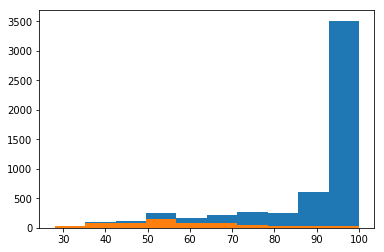

[   0    1    2 ... 1761 1762 1763] [1764 1765 1766 1767 1768 1769 1770 1771 1772 1773 1774 1775 1776 1777
 1778 1779 1780 1781 1782 1783 1784 1785 1786 1787 1788 1789 1790 1791
 1792 1793 1794 1795 1796 1797 1798 1799 1800 1801 1802 1803 1804 1805
 1806 1807 1808 1809 1810 1811 1812 1813 1814 1815 1816 1817 1818 1819
 1820 1821 1822 1823 1824 1825 1826 1827 1828 1829 1830 1831 1832 1833
 1834 1835 1836 1837 1838 1839 1840 1841 1842 1843 1844 1845 1846 1847
 1848 1849 1850 1851 1852 1853 1854 1855 1856 1857 1858 1859 1860 1861
 1862 1863 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875
 1876 1877 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889
 1890 1891 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903
 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917
 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931
 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945
 1946 1947 1948 1949 1950 1951 1952 1953 

<Figure size 432x288 with 0 Axes>

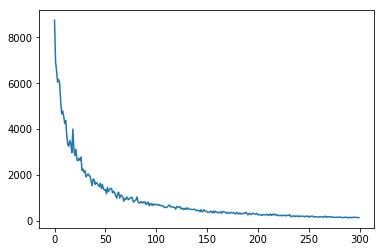

<Figure size 432x288 with 0 Axes>

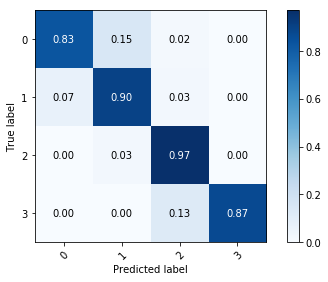

<Figure size 432x288 with 0 Axes>

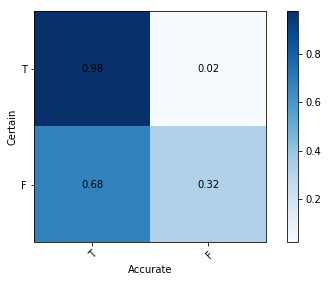

<Figure size 432x288 with 0 Axes>

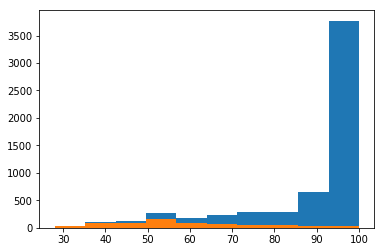

Target output:  2
F1 SCORE:  0.8950956526466729 +- 0.0003759662489835142 [0.896310039167182, 0.8949357520786092, 0.8942961800104657, 0.894395853579527, 0.8955404383975812]
P(Acc | Certain):  0.9803600398536452 +- 0.000702946151620945 [0.9817415730337079, 0.9819890368050117, 0.9804913294797688, 0.9792178770949721, 0.9783603828547649]
P(Acc | Uncertain):  0.6683641473146242 +- 0.002442516013157925 [0.6607281177381874, 0.6666666666666666, 0.6679316888045541, 0.6709829311359623, 0.6755113322277502]
[ 441  442  443 ... 2202 2203 2204] [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 1

<Figure size 432x288 with 0 Axes>

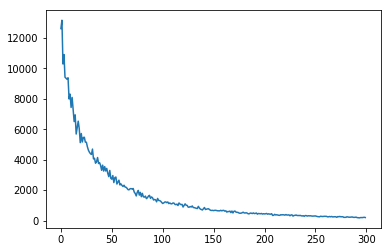

<Figure size 432x288 with 0 Axes>

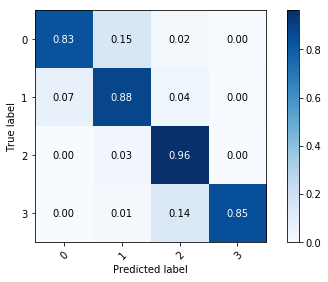

<Figure size 432x288 with 0 Axes>

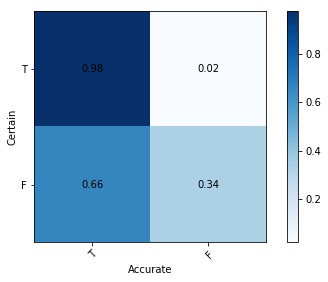

<Figure size 432x288 with 0 Axes>

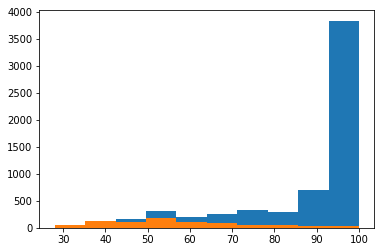

[   0    1    2 ... 2202 2203 2204] [441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458
 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476
 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494
 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512
 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530
 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548
 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566
 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584
 585 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600 601 602
 603 604 605 606 607 608 609 610 611 612 613 614 615 616 617 618 619 620
 621 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637 638
 639 640 641 642 643 644 645 646 647 648 649 650 651 652 653 654 655 656
 657 658 659 660 661 662 663 664 665 666 667 668 669 670 671 672 673 674
 675 676 677 67

<Figure size 432x288 with 0 Axes>

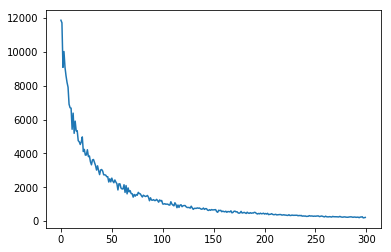

<Figure size 432x288 with 0 Axes>

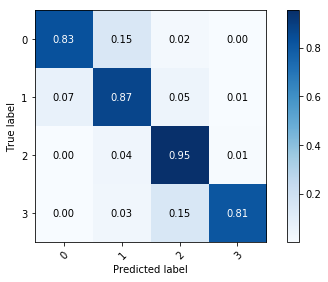

<Figure size 432x288 with 0 Axes>

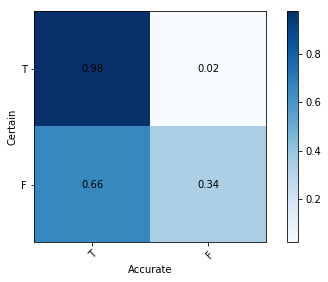

<Figure size 432x288 with 0 Axes>

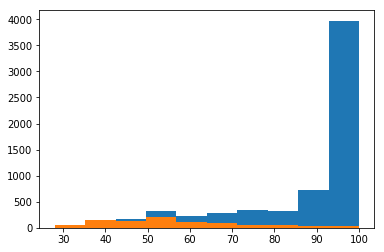

[   0    1    2 ... 2202 2203 2204] [ 882  883  884  885  886  887  888  889  890  891  892  893  894  895
  896  897  898  899  900  901  902  903  904  905  906  907  908  909
  910  911  912  913  914  915  916  917  918  919  920  921  922  923
  924  925  926  927  928  929  930  931  932  933  934  935  936  937
  938  939  940  941  942  943  944  945  946  947  948  949  950  951
  952  953  954  955  956  957  958  959  960  961  962  963  964  965
  966  967  968  969  970  971  972  973  974  975  976  977  978  979
  980  981  982  983  984  985  986  987  988  989  990  991  992  993
  994  995  996  997  998  999 1000 1001 1002 1003 1004 1005 1006 1007
 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1019 1020 1021
 1022 1023 1024 1025 1026 1027 1028 1029 1030 1031 1032 1033 1034 1035
 1036 1037 1038 1039 1040 1041 1042 1043 1044 1045 1046 1047 1048 1049
 1050 1051 1052 1053 1054 1055 1056 1057 1058 1059 1060 1061 1062 1063
 1064 1065 1066 1067 1068 1069 1070 1071 

<Figure size 432x288 with 0 Axes>

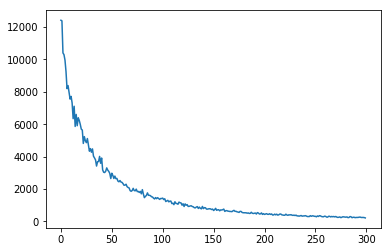

<Figure size 432x288 with 0 Axes>

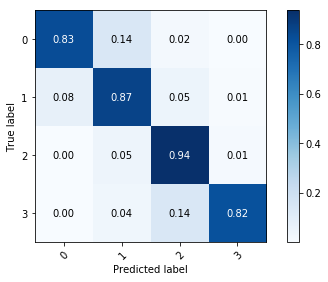

<Figure size 432x288 with 0 Axes>

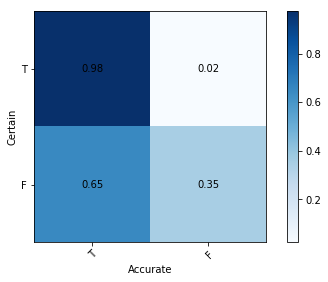

<Figure size 432x288 with 0 Axes>

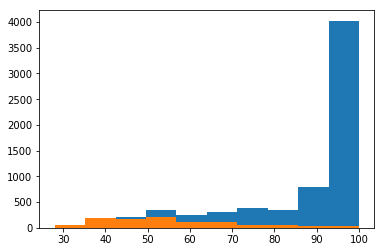

[   0    1    2 ... 2202 2203 2204] [1323 1324 1325 1326 1327 1328 1329 1330 1331 1332 1333 1334 1335 1336
 1337 1338 1339 1340 1341 1342 1343 1344 1345 1346 1347 1348 1349 1350
 1351 1352 1353 1354 1355 1356 1357 1358 1359 1360 1361 1362 1363 1364
 1365 1366 1367 1368 1369 1370 1371 1372 1373 1374 1375 1376 1377 1378
 1379 1380 1381 1382 1383 1384 1385 1386 1387 1388 1389 1390 1391 1392
 1393 1394 1395 1396 1397 1398 1399 1400 1401 1402 1403 1404 1405 1406
 1407 1408 1409 1410 1411 1412 1413 1414 1415 1416 1417 1418 1419 1420
 1421 1422 1423 1424 1425 1426 1427 1428 1429 1430 1431 1432 1433 1434
 1435 1436 1437 1438 1439 1440 1441 1442 1443 1444 1445 1446 1447 1448
 1449 1450 1451 1452 1453 1454 1455 1456 1457 1458 1459 1460 1461 1462
 1463 1464 1465 1466 1467 1468 1469 1470 1471 1472 1473 1474 1475 1476
 1477 1478 1479 1480 1481 1482 1483 1484 1485 1486 1487 1488 1489 1490
 1491 1492 1493 1494 1495 1496 1497 1498 1499 1500 1501 1502 1503 1504
 1505 1506 1507 1508 1509 1510 1511 1512 

<Figure size 432x288 with 0 Axes>

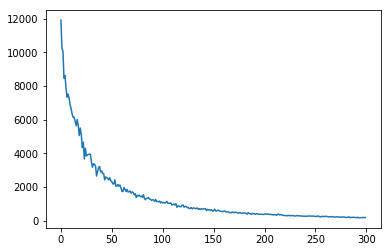

<Figure size 432x288 with 0 Axes>

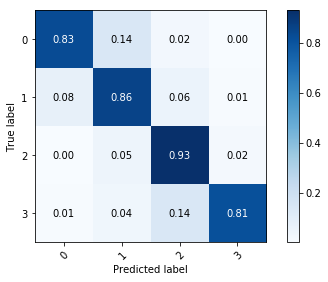

<Figure size 432x288 with 0 Axes>

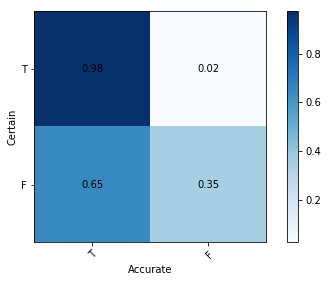

<Figure size 432x288 with 0 Axes>

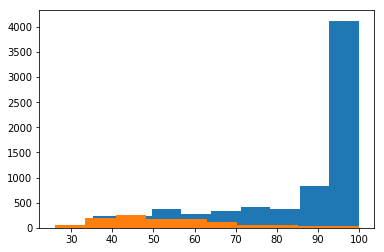

[   0    1    2 ... 1761 1762 1763] [1764 1765 1766 1767 1768 1769 1770 1771 1772 1773 1774 1775 1776 1777
 1778 1779 1780 1781 1782 1783 1784 1785 1786 1787 1788 1789 1790 1791
 1792 1793 1794 1795 1796 1797 1798 1799 1800 1801 1802 1803 1804 1805
 1806 1807 1808 1809 1810 1811 1812 1813 1814 1815 1816 1817 1818 1819
 1820 1821 1822 1823 1824 1825 1826 1827 1828 1829 1830 1831 1832 1833
 1834 1835 1836 1837 1838 1839 1840 1841 1842 1843 1844 1845 1846 1847
 1848 1849 1850 1851 1852 1853 1854 1855 1856 1857 1858 1859 1860 1861
 1862 1863 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875
 1876 1877 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889
 1890 1891 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903
 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917
 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931
 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945
 1946 1947 1948 1949 1950 1951 1952 1953 

<Figure size 432x288 with 0 Axes>

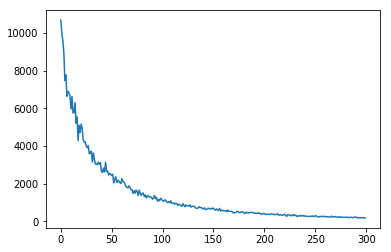

<Figure size 432x288 with 0 Axes>

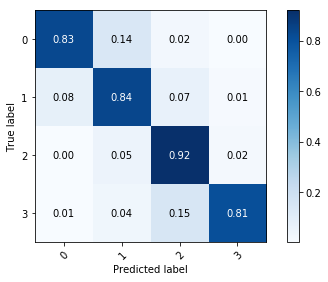

<Figure size 432x288 with 0 Axes>

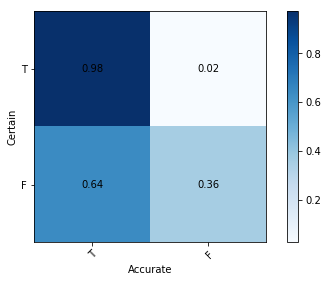

<Figure size 432x288 with 0 Axes>

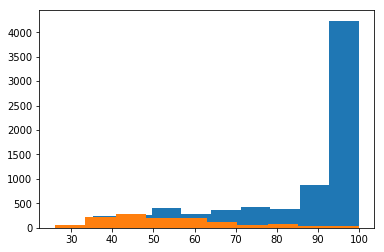

Target output:  3
F1 SCORE:  0.869661112008156 +- 0.004955399164153763 [0.8843537414965986, 0.8763505402160864, 0.8687326782564879, 0.8626327724072085, 0.8562358276643991]
P(Acc | Certain):  0.9771678169164522 +- 0.0003743353760335433 [0.9783576051779935, 0.977613393030952, 0.9769419769419769, 0.9767314034444852, 0.9761947059868538]
P(Acc | Uncertain):  0.6533457601664097 +- 0.0033077988038675266 [0.6642992424242424, 0.6559322033898305, 0.6524367208160181, 0.6494351249572065, 0.6446255092447508]
[ 441  442  443 ... 2202 2203 2204] [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 

<Figure size 432x288 with 0 Axes>

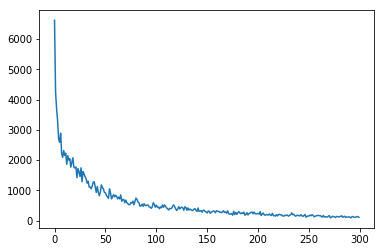

<Figure size 432x288 with 0 Axes>

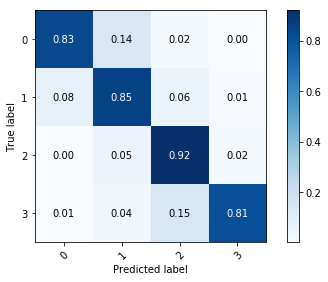

<Figure size 432x288 with 0 Axes>

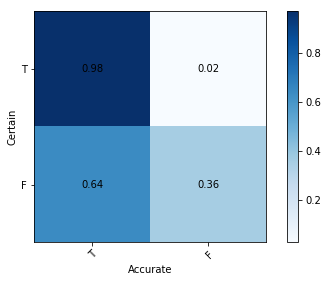

<Figure size 432x288 with 0 Axes>

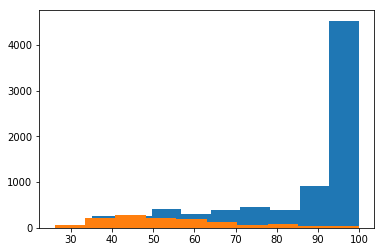

[   0    1    2 ... 2202 2203 2204] [441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458
 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476
 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494
 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512
 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530
 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548
 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566
 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584
 585 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600 601 602
 603 604 605 606 607 608 609 610 611 612 613 614 615 616 617 618 619 620
 621 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637 638
 639 640 641 642 643 644 645 646 647 648 649 650 651 652 653 654 655 656
 657 658 659 660 661 662 663 664 665 666 667 668 669 670 671 672 673 674
 675 676 677 67

<Figure size 432x288 with 0 Axes>

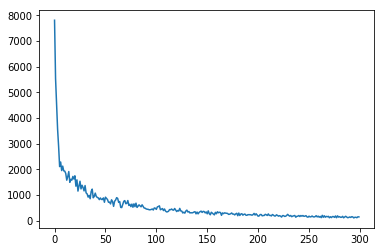

<Figure size 432x288 with 0 Axes>

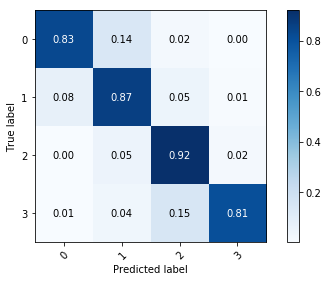

<Figure size 432x288 with 0 Axes>

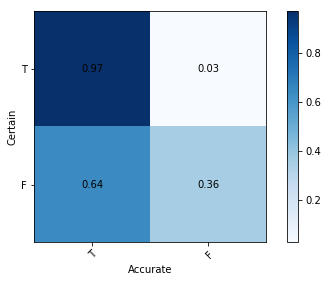

<Figure size 432x288 with 0 Axes>

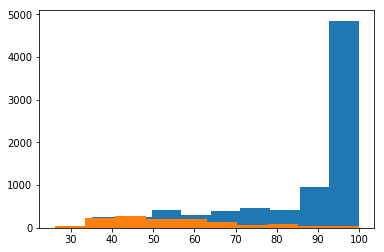

[   0    1    2 ... 2202 2203 2204] [ 882  883  884  885  886  887  888  889  890  891  892  893  894  895
  896  897  898  899  900  901  902  903  904  905  906  907  908  909
  910  911  912  913  914  915  916  917  918  919  920  921  922  923
  924  925  926  927  928  929  930  931  932  933  934  935  936  937
  938  939  940  941  942  943  944  945  946  947  948  949  950  951
  952  953  954  955  956  957  958  959  960  961  962  963  964  965
  966  967  968  969  970  971  972  973  974  975  976  977  978  979
  980  981  982  983  984  985  986  987  988  989  990  991  992  993
  994  995  996  997  998  999 1000 1001 1002 1003 1004 1005 1006 1007
 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1019 1020 1021
 1022 1023 1024 1025 1026 1027 1028 1029 1030 1031 1032 1033 1034 1035
 1036 1037 1038 1039 1040 1041 1042 1043 1044 1045 1046 1047 1048 1049
 1050 1051 1052 1053 1054 1055 1056 1057 1058 1059 1060 1061 1062 1063
 1064 1065 1066 1067 1068 1069 1070 1071 

<Figure size 432x288 with 0 Axes>

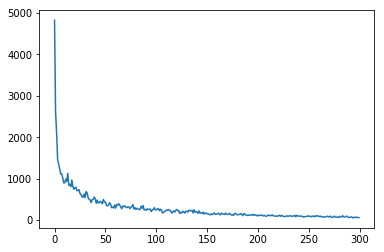

<Figure size 432x288 with 0 Axes>

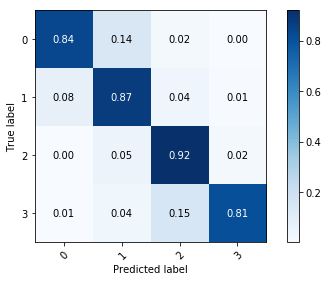

<Figure size 432x288 with 0 Axes>

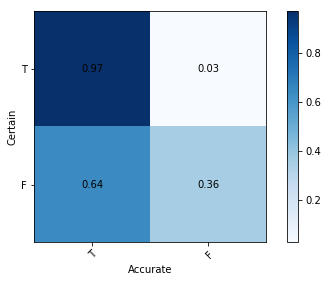

<Figure size 432x288 with 0 Axes>

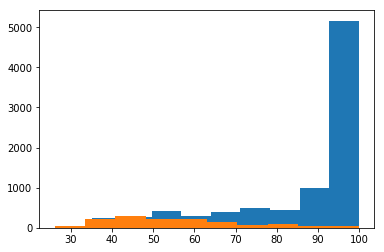

[   0    1    2 ... 2202 2203 2204] [1323 1324 1325 1326 1327 1328 1329 1330 1331 1332 1333 1334 1335 1336
 1337 1338 1339 1340 1341 1342 1343 1344 1345 1346 1347 1348 1349 1350
 1351 1352 1353 1354 1355 1356 1357 1358 1359 1360 1361 1362 1363 1364
 1365 1366 1367 1368 1369 1370 1371 1372 1373 1374 1375 1376 1377 1378
 1379 1380 1381 1382 1383 1384 1385 1386 1387 1388 1389 1390 1391 1392
 1393 1394 1395 1396 1397 1398 1399 1400 1401 1402 1403 1404 1405 1406
 1407 1408 1409 1410 1411 1412 1413 1414 1415 1416 1417 1418 1419 1420
 1421 1422 1423 1424 1425 1426 1427 1428 1429 1430 1431 1432 1433 1434
 1435 1436 1437 1438 1439 1440 1441 1442 1443 1444 1445 1446 1447 1448
 1449 1450 1451 1452 1453 1454 1455 1456 1457 1458 1459 1460 1461 1462
 1463 1464 1465 1466 1467 1468 1469 1470 1471 1472 1473 1474 1475 1476
 1477 1478 1479 1480 1481 1482 1483 1484 1485 1486 1487 1488 1489 1490
 1491 1492 1493 1494 1495 1496 1497 1498 1499 1500 1501 1502 1503 1504
 1505 1506 1507 1508 1509 1510 1511 1512 

<Figure size 432x288 with 0 Axes>

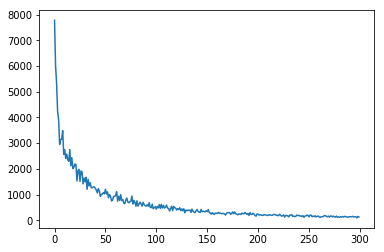

<Figure size 432x288 with 0 Axes>

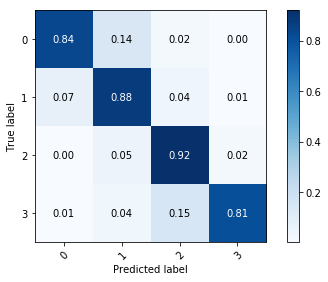

<Figure size 432x288 with 0 Axes>

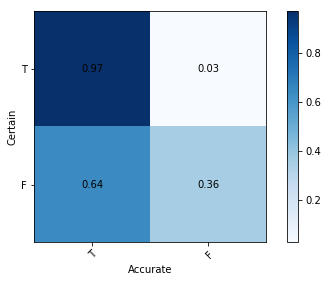

<Figure size 432x288 with 0 Axes>

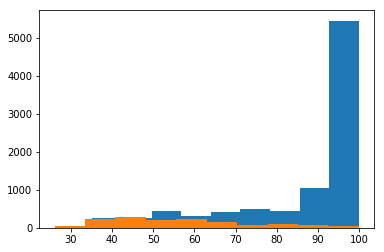

[   0    1    2 ... 1761 1762 1763] [1764 1765 1766 1767 1768 1769 1770 1771 1772 1773 1774 1775 1776 1777
 1778 1779 1780 1781 1782 1783 1784 1785 1786 1787 1788 1789 1790 1791
 1792 1793 1794 1795 1796 1797 1798 1799 1800 1801 1802 1803 1804 1805
 1806 1807 1808 1809 1810 1811 1812 1813 1814 1815 1816 1817 1818 1819
 1820 1821 1822 1823 1824 1825 1826 1827 1828 1829 1830 1831 1832 1833
 1834 1835 1836 1837 1838 1839 1840 1841 1842 1843 1844 1845 1846 1847
 1848 1849 1850 1851 1852 1853 1854 1855 1856 1857 1858 1859 1860 1861
 1862 1863 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875
 1876 1877 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889
 1890 1891 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903
 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917
 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931
 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945
 1946 1947 1948 1949 1950 1951 1952 1953 

<Figure size 432x288 with 0 Axes>

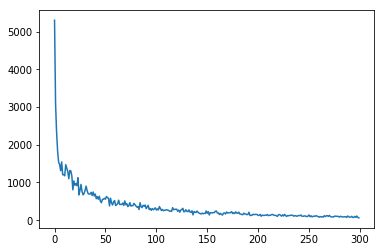

<Figure size 432x288 with 0 Axes>

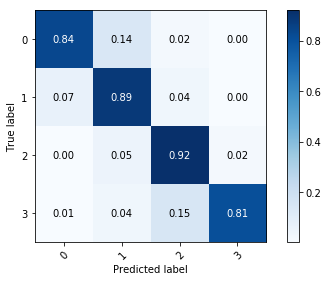

<Figure size 432x288 with 0 Axes>

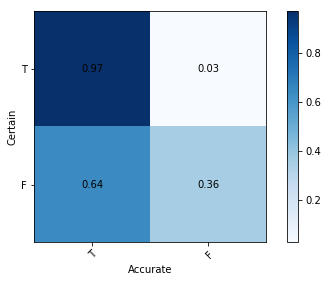

<Figure size 432x288 with 0 Axes>

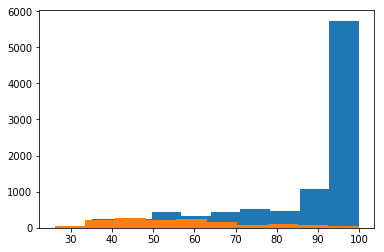

Target output:  4
F1 SCORE:  0.8627400873141777 +- 0.0014700417577166714 [0.858330633840838, 0.8607503607503607, 0.8631568569456767, 0.8647959183673469, 0.8666666666666667]
P(Acc | Certain):  0.9735918880262171 +- 0.0006130107526609332 [0.9751832111925383, 0.9744714173844949, 0.9739490822972173, 0.9723818870040656, 0.9719738422527693]
P(Acc | Uncertain):  0.6425226549823247 +- 0.0002555501246922896 [0.6429229352164568, 0.6418450406994272, 0.6421612046058459, 0.6424224862358736, 0.6432616081540203]


<Figure size 432x288 with 0 Axes>

In [7]:
simulate_broken_sensor = False #experimental and not fully implemented yet

y_pred_kfold =[]
y_actuals_kfold=[]
mse_kfold=[]
certainties_kfold=[]
confidences_kfold=[]
DL_model_kfold =[]
final_results =[]


for target in range(len(output_sizes)):
    selected_output = target
    output_size =output_sizes[selected_output]
    bnn_wrapper = BNN_Wrapper(BNN_Full,output_size=output_size)
    
    kfold_times = 0
    kfold_limit = 5
    #kfold validation training
    kf = KFold(n_splits=5)
    f1_score_model_kfold=[]
    p_accurate_certain_kfold=[]
    p_accurate_uncertain_kfold=[]
    
    for train, test in kf.split(X_data,y=Y_data):
        
        if(kfold_times >kfold_limit):
            break
        print("%s %s" % (train, test))
        
    
        x_train=X_data[train]
        y_train=Y_data[train,selected_output]
        x_test=X_data[test]
        y_test=Y_data[test,selected_output]
        
        #simulate broken sensors on test set
        if simulate_broken_sensor == True:
            x_test_brokenSensor = Variable(torch.from_numpy(x_test).float()).repeat(x_train.shape[-1]+1,1,1,1)    
            for corrupted_sensor in range(x_train.shape[-1]):
                x_test_brokenSensor[corrupted_sensor,:,:,corrupted_sensor] =torch.randn_like(x_test_brokenSensor[corrupted_sensor,:,:,corrupted_sensor]) 
            x_test_brokenSensor = x_test_brokenSensor.view(-1,x_test_brokenSensor.shape[2],x_test_brokenSensor.shape[3])
            x_test_brokenSensor = x_test_brokenSensor.cpu().detach().numpy()
            x_test = copy(x_test_brokenSensor)
        
        
        y_test_tensor = Variable(torch.from_numpy(y_test).long())   
        if simulate_broken_sensor == True:
            y_test_tensor_repeated = y_test_tensor.repeat(x_train.shape[-1]+1,1)
            y_test_tensor_repeated = y_test_tensor_repeated.view(-1)    
        elif simulate_broken_sensor == False:
            y_test_tensor_repeated = y_test_tensor
    
        #perform feature extraction on train and test
        df_feats_train = bnn_wrapper.extract_features(x_train)
        x_train = df_feats_train.values 
        df_feats_test = bnn_wrapper.extract_features(x_test)
        x_test = df_feats_test.values 
        
        #train model
        bnn_wrapper.train_model(x_train,y_train,learning_rate= learning_rate,num_epochs = num_epochs)
    
        #predict using model
        y_pred_test,certainties,confidences = bnn_wrapper.predict_model_wUnc(x_test,num_samples=num_samples)
        
        #now form all the kfolds  
        DL_model_kfold.append(bnn_wrapper.trained_model)
        y_pred_kfold.append(y_pred_test)
        y_actuals_kfold.append(y_test_tensor_repeated.cpu().detach().numpy())
        certainties_kfold.append(np.array(certainties))
        confidences_kfold.append(np.array(confidences))
        kfold_times = kfold_times+1
        
        #evaluate model
        y_true_np=np.array(y_actuals_kfold).reshape(-1)
        y_pred_np=np.array(y_pred_kfold).reshape(-1)
        certainties_np = np.array(certainties_kfold).reshape(-1)
        
        f1_score_model, p_accurate_certain, p_accurate_uncertain = bnn_wrapper.evaluate_model(y_true_np,y_pred_np,certainties_np,certainty_threshold=certainty_threshold)
        f1_score_model_kfold.append(f1_score_model)
        p_accurate_certain_kfold.append(p_accurate_certain)
        p_accurate_uncertain_kfold.append(p_accurate_uncertain)
    
    print("Target output: ", selected_output)
    print("F1 SCORE: ",np.mean(f1_score_model_kfold),"+-",sem(f1_score_model_kfold), f1_score_model_kfold)
    print("P(Acc | Certain): ",np.mean(p_accurate_certain_kfold),"+-",sem(p_accurate_certain_kfold),p_accurate_certain_kfold)
    print("P(Acc | Uncertain): ",np.mean(p_accurate_uncertain_kfold),"+-",sem(p_accurate_uncertain_kfold),p_accurate_uncertain_kfold)

    final_results.append([f1_score_model_kfold, p_accurate_certain_kfold, p_accurate_uncertain_kfold])
    
    pickle.dump(bnn_wrapper, open( pickle_path+"bnn_wrapper_"+str(selected_output)+".p", "wb" ) )


In [9]:
# print results
task_names = ["Cooler Condition", "Valve Condition", "Internal Pump Leakage", "Accumulator", "Stable Flag"]

for i in range(len(final_results)):
    f1_score_model_kfold = final_results[i][0]
    p_accurate_certain_kfold = final_results[i][1]
    p_accurate_uncertain_kfold = final_results[i][2]
    print("Target output: ", task_names[i])
    print("F1 SCORE: ",np.mean(f1_score_model_kfold),"+-",sem(f1_score_model_kfold), f1_score_model_kfold)
    print("P(Acc | Certain): ",np.mean(p_accurate_certain_kfold),"+-",sem(p_accurate_certain_kfold),p_accurate_certain_kfold)
    print("P(Acc | Uncertain): ",np.mean(p_accurate_uncertain_kfold),"+-",sem(p_accurate_uncertain_kfold),p_accurate_uncertain_kfold)
    print("\n")


Target output:  Cooler Condition
F1 SCORE:  0.9935298563869992 +- 0.0006539809038948887 [0.9909297052154195, 0.9943310657596371, 0.9939531368102796, 0.9943310657596371, 0.9941043083900227]
P(Acc | Certain):  0.9948817684799582 +- 0.0011175664038947306 [0.9908883826879271, 0.9942987457240593, 0.9954163483575248, 0.9965576592082617, 0.9972477064220183]
P(Acc | Uncertain):  0.8773333333333333 +- 0.05470547817544079 [1.0, 1.0, 0.8571428571428571, 0.8095238095238095, 0.72]


Target output:  Valve Condition
F1 SCORE:  0.9230903790087464 +- 0.010276024503798158 [0.9554043839758125, 0.9358600583090378, 0.9195011337868481, 0.9062736205593348, 0.8984126984126984]
P(Acc | Certain):  0.9894242947009813 +- 0.0018893413199378155 [0.9948892674616695, 0.9918730650154799, 0.9897345132743363, 0.9862114248194354, 0.9844132029339854]
P(Acc | Uncertain):  0.6446576085351627 +- 0.0023821201108178485 [0.6442953020134228, 0.6481113320079522, 0.6372688477951636, 0.6424702058504875, 0.6511423550087874]


Target